In [1]:
import clmm
import numpy as np
import matplotlib.pyplot as plt

# Conversion from $200m$ to $500c$ overdensity definition

we define a background cosmology :

In [2]:
cosmo = clmm.Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)

## Define NFW mass profile

First, We need a function $M(<r)$ that provides the mass enclosed in a radius $r$, given a spherical overdensity definition (choice of background density, and $\Delta$). We build a class with such method.

## Example
### First SOD definition

We define halo parameters following the $200m$ overdensity definition:
1. the mass $M_{200m}$ 
2. the concentration $c_{200m}$

In [3]:
#cluster redshift
z = 0.4
#first SOD definition
M1 = 1e14
c1 = 3
massdef1 = 'mean'
delta_mdef1 = 200

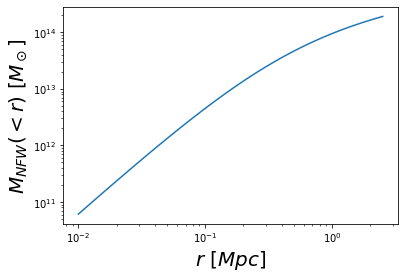

In [4]:
nfw_def1 = clmm.profiles.NFW(M1, c1, z, massdef1, delta_mdef1, cosmo)
r = np.logspace(-2, 0.4, 100)
plt.loglog(r, nfw_def1.M(r))
plt.xlabel(r'$r\ [Mpc]$', fontsize = 20)
plt.ylabel(r'$M_{NFW}(<r)\ [M_\odot]$', fontsize = 20)
plt.show()

### Second SOD definition
we choose the second definition (here, we choose 500c)

In [5]:
#2nd mass definition
massdef2 = 'critical'
delta_mdef2 = 500

### Conversion between 200m to 500c

To find $M_2$ and $c_2$ following the second SOD definition, we solve the system:
- $M_{M_1, c_1}(r_1) = M_{M_2, c_2}(r_1)$
- $M_{M_1, c_1}(r_2) = M_{M_2, c_2}(r_2)$

where $M_{M_i, c_i}(r)$ is the mass enclosed within a sphere or radius $r$, following a parametrization with overdensity mass $M_i$ and concentration $c_i$. Here, $r_i$ is the overdensity radius $r_{\Delta_i}$ following the overdensity definition $i$, given by
$$
r_{\Delta_i} = \left(\frac{3M_{\Delta_i}}{4\pi \Delta_i \rho_{\rm bckgd,i}}\right)^{1/3}
$$
This leads to 2 equations, knowing that $M_{M_i, c_i}(r_i) = M_{\Delta_i}$
- $M_1 = M_{M_2, c_2}(r_1)$
- $M_{M_1, c_1}(r_2) = M_2$

In [6]:
M2, c2 = clmm.profiles.convert_def(M1, c1, z, massdef1, delta_mdef1, massdef2, delta_mdef2, cosmo)
print(f'M2 = {M2:.2e} M_sun')
print(f'c2 = {c2:.2f}')

M2 = 4.33e+13 M_sun
c2 = 1.33


Alternatively, the conversion can be done by "to_def" method of an NFW object, which is underlyingly the same as "convert_def", and the output is a new NFW object with the second SOD definition.

In [7]:
nfw_def2 = nfw_def1.to_def(massdef2, delta_mdef2)

To test the methods, we plot the bias between the 2 mass profiles corresponding respectively to the 2 SOD definitions.
    $$
    \frac{M_{M_2, c_2}(<r) - M_{M_1, c_1}(<r)}{M_{M_1, c_1}(<r)}
    $$

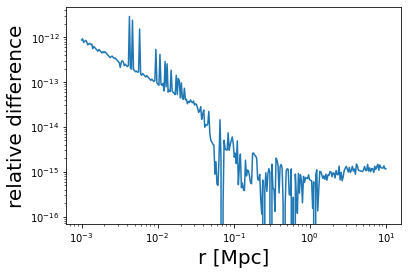

In [8]:
r = np.logspace(-3, 1, 300)
plt.loglog(r, abs((nfw_def2.M(r)-nfw_def1.M(r))/nfw_def1.M(r)), ls='-')
plt.xlabel('r [Mpc]', fontsize = 20)
plt.ylabel(r'relative difference', fontsize = 20)
plt.show()